# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель исследования**
  
Создать систему рекомендаций тарифов на основе данных о использовании мобильной сети и мобильного трафика пользователями

**Ход исследования**

 - Сформируем обучающую и тестовую выборки
 - Изучим точность модели `случайного леса` и `логистической регрессии`
 - Проверим наиболее точную модель на тестовой выборке
 - Проверим наиболее точную модель в тесте на адекватность

## Откройте и изучите файл

Импортируем библиотеки

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

Импортируем данные

In [2]:
df = pd.read_csv('users_behavior.csv')

Познакомимся с датасетом

На первый взгляд, нет отсутсвующих значений

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Аномально больших или множество нулевых значений в нашем датасете нет

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Посмотрим на распределение целевого признака

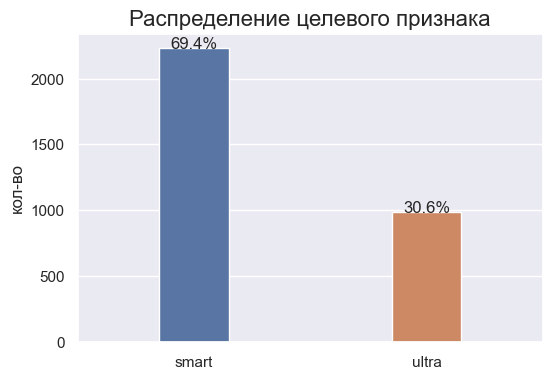

In [18]:
sns.set_theme()
percentage = [len(df[df['is_ultra'] == 0]) / df.shape[0],
              len(df[df['is_ultra'] == 1]) / df.shape[0]]
plt.figure(figsize=(6, 4))
ax = sns.barplot(y=df['is_ultra'].value_counts(), 
                 x=['smart', 'ultra'], 
                 width=0.3)
plt.title('Распределение целевого признака', fontsize=16)
plt.ylabel('кол-во')

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1%}'.format(percentage[i]), (x, y), ha='center')
plt.show()

Посмотрим на корреляцию признаков

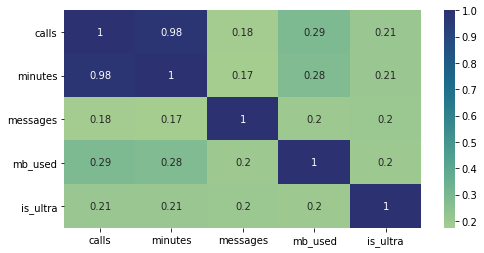

In [5]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(), annot=True, cmap='crest')
plt.show()

В нашем датасете целевой признак распределен не равномерно, что стоить учесть при обучении модели.  
Также, есть зависимость между признаками `calls`(кол-во звонков) и `minutes`(кол-во потраченных минут на звонки)

## Разбейте данные на выборки

Разобьем наш датасет на выборку для обучения и теста. Используем параметр *stratify*, чтобы в выборках сохранилось изначальное распределение таргета

In [20]:
X = df.drop(['is_ultra'], axis=1)
y = df['is_ultra']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345, stratify=y)

print('Train size: ', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size:  2571
Test size:  643


## Исследуйте модели

### Лес деревьев

Подберем гиперпараметры для леса деревьев

In [45]:
model = RandomForestClassifier(random_state=12345)
params = {'n_estimators':np.linspace(100, 500, 20, dtype=int),
          'max_depth':range(5, 10)}
gs = GridSearchCV(model, params, n_jobs=5, scoring='accuracy', cv=3)
gs.fit(X_train, y_train)
print('Получили лучшую accuracy:')
gs.best_score_

Получили лучшую accuracy:


0.8066900038895372

С такими гиперпараметрами:

In [46]:
gs.best_params_

{'max_depth': 9, 'n_estimators': 457}

### Логистическая регрессия

Модель - логистическая регрессия. У нее попробуем поменять гиперпараметр итераций обучения от 100 до 1000 с шагом в 100

In [41]:
model = LogisticRegression()
params = {'C':np.logspace(-6, 2, 50)}
gs = GridSearchCV(model, params, n_jobs=5, scoring='accuracy', cv=3)
gs.fit(X_train, y_train)
print('Получили лучшую accuracy:')
gs.best_score_

Получили лучшую accuracy:


0.7436795021392454

С такими гиперпараметрами:

In [42]:
gs.best_params_

{'C': 1.4563484775012444e-06}

### Итог
---
По итогам, наиболее точной в предсказаниях оказалась модель случайного леса. Ее мы дальше и проверим на тестовой выборке, а также в тесте на адекватность

## Проверьте модель на тестовой выборке

In [47]:
model = RandomForestClassifier(n_estimators=457, max_depth=9,
                               random_state=12345)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8133748055987559

Точность оказалась на уровне результатов кросс-валидации тренировочной выборки

---
Посмотрим еще на разные метрики модели

Матрица ошибок

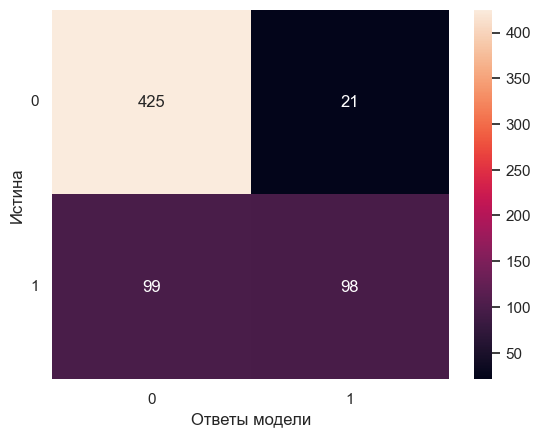

In [48]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Ответы модели')
plt.ylabel('Истина')
plt.yticks(rotation=0);

Precision, recall и F1

In [50]:
report = classification_report(y_test, y_pred, target_names=['Smart', 'Ultra'])
print(report)

              precision    recall  f1-score   support

       Smart       0.81      0.95      0.88       446
       Ultra       0.82      0.50      0.62       197

    accuracy                           0.81       643
   macro avg       0.82      0.73      0.75       643
weighted avg       0.81      0.81      0.80       643



Наша модель точнее рекомендует тариф Smart, сказывается дизбаланс классов в датасете. Наша модель почти точно найдет людей, которым подойдет тариф Smart, а вот тех, кому подойдет Ultra - только 50%. Я бы вернулся к заказчику с уточнением, какие метрики для него важнее.

## Проверьте модели на адекватность

In [54]:
dummy_cls = DummyClassifier(strategy="most_frequent")
dummy_cls.fit(X_train, y_train)
print('Точность случайной модели', '{:.2f}'.format(dummy_cls.score(X_test, y_test)))

Точность случайной модели 0.69


Точность модели, которая всегда будет отвечать 0 составляет 0.69, а у нашей 0.81. Это значит, наша модель пусть немного, но все же умнее случайной

## Итог

При создании системы рекомендаций протестировали модели:
- Случайный лес
- Логистическая регрессия

Самой точной оказалась `модель Случайного леса` - с точностью 0.81, которая также успешно прошла проверку на адекватность.